In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch   
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torchvision 
from torchvision import datasets      
import torchvision.transforms as T

from torch.nn.utils.rnn import pad_sequence
import os
from collections import Counter
import spacy #NLP library for tokenizing our vocab


In [2]:
device = (
    # CUDA is a an Nvidia GPU model that lets use do calculations on GPU
    "cuda" if torch.cuda.is_available()
    else
    
    # MPS is similar to Cuda
    "mps" if torch.backends.mps.is_available()
    else
    
    # Not optimal (training/testing speed reduced greatly)
    "cpu"
)

device = "gpu"
print(f"Using {device} device")

Using gpu device


In [3]:
#SETTING UP DATASET
path = "Flickr8k"
captionFile = path + "/captions.txt"
data = pd.read_csv(captionFile)

print(len(data), "Image Captions")
data.head(3)

40455 Image Captions


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .


In [4]:
#Spacy is a NLP library that splits sentences and tokenizes words
spacyEnglish = spacy.load("en_core_web_sm")

example = "Never gonna give you up"
for token in spacyEnglish.tokenizer(example):
    print(token)

Never
gon
na
give
you
up


In [5]:
# We will build a lexicon from words that appear in our training
# captions enough times (frequency threshold). We will assign a numerical
# value to each word in vocab: caption --> numeric tensor

class Vocabulary:
    
    padID = 0
    
    def __init__(self, frequencyThreshold):
        
        # Decoder dictionary
        # Default tokens for padding, start&end of sentence, and unknown word
        self.intToString = {0:"<PAD>", 1:"<SOS>", 2:"<EOS>", 3:"<UNK>"}

        # Encoder dictionary
        self.stringToInt = {word:num for num,word in self.intToString.items()}

        # How often a word needs to appear to be given it's own token
        self.frequencyThreshold = frequencyThreshold

    # Overload python len() function
    def __len__(self):
        return len(self.intToString)

    # Returns list of tokens (words or subwords) from text
    @staticmethod
    def tokenize(text):
        return [token.text.lower() for token in spacyEnglish.tokenizer(text)]


    # Reads in sentences (captions) and words that appear enough get their own token
    # Otherwise they are defaultly assigned <UNK>
    def buildVocab(self, sentences):
        freq = Counter()
        i = 4 # Starts at 4 b/c we already have 4 default tokens

        for sentence in sentences:
            for word in self.tokenize(sentence):
                freq[word] += 1

                # It has become a common enough word to be a nondefault token
                if freq[word] == self.frequencyThreshold:
                    self.stringToInt[word] = i
                    self.intToString[i] = word
                    i += 1

    # Takes a new sentence and returns a tensor of eachs of it's tokens numerical representation
    def numericalize(self, text):
        tokens = self.tokenize(text)
        return [self.stringToInt[token] if token in self.stringToInt else self.stringToInt["<UNK>"] for token in tokens]


        

In [6]:
lyrics = [
    "We\'re no strangers to love",
    "You know the rules and so do I",
    "A full commitment\'s what I\'m thinking of",
    "You wouldn't get this from any other guy",
    "I just wanna tell you how I\'m feeling",
    "Gotta make you understand",
    "Never gonna give you up",
    "Never gonna let you down",
    "Never gonna run around and desert you",
    "Never gonna make you cry",
    "Never gonna say goodbye",
    "Never gonna tell a lie and hurt you"
]

v = Vocabulary(2)
v.buildVocab(lyrics)
print(v.stringToInt)

print(v.numericalize("Never gonna give you up"))

{'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'i': 4, 'you': 5, "'m": 6, 'never': 7, 'gon': 8, 'na': 9, 'and': 10, 'make': 11, 'tell': 12, 'a': 13}
[7, 8, 9, 3, 5, 3]


In [7]:
# Inherit from PyTorch dataset class so that we can pass it into a dataloader for batching 
class FlickrDataset(Dataset):

    # Transform is any preprocessing/normalization function that images need to go through
    # before training/testing/eval can start (e.g making all images the same size)
    def __init__(self, captionFile, imageFile, split, randomSeed, transform=None, frequencyThreshold=5):


        # Validate parameters
        self.split = split
        assert split in {"TRAIN", "TEST"}
        
        self.captionDataframe = pd.read_csv(captionFile)
        self.imageFile = imageFile
        self.transform = transform
        self.captionsPerImage = 5

        
        
        # Create split using the given random seed
        # reset_index() unshuffles the indexes after we sample
        trainingData = self.captionDataframe.sample(frac = 0.90, random_state=randomSeed).reset_index() 
        testingData = self.captionDataframe.drop(trainingData.index).reset_index()
        if split == "TRAIN":
            self.imageList = trainingData["image"]
            self.captionList = trainingData["caption"]
        elif split == "TEST":
            self.imageList = testingData["image"]
            self.captionList = testingData["caption"]

        
        # Setup vocabulary tokenizer using all the captions in the dataset
        self.vocab = Vocabulary(frequencyThreshold)
        self.vocab.buildVocab(self.captionDataframe["caption"].tolist())

        # Create list of actual (non-padded) caption lengths (+2 is for the <start> and <end> sentence tokens)
        self.captionLengths = [len(caption)+2 for caption in self.captionList]

    
    def __len__(self):
        return len(self.captionList)
    
    # Overloads the [] operator.
    # dataset[index] returns a PIL image and the tokenized caption tensor
    def __getitem__(self, index):

        # Get the caption, and load the image as a PIL RBG Image
        caption = self.captionList[index]
        imageName = self.imageList[index]
        image = Image.open(os.path.join(self.imageFile, imageName)).convert("RGB")

        # Apply the specified transforms
        if self.transform is not None:
            image = self.transform(image)

        # Get the numerical tokenizec caption
        vector = [self.vocab.stringToInt["<SOS>"]] # Start vector token
        vector += self.vocab.numericalize(caption)
        vector.append(self.vocab.stringToInt["<EOS>"]) # End vector token

        # For Bleu evaluation, might be better to return all captions connected to this image in one go. But for now... it don't matter
        return image, torch.tensor(vector), self.captionLengths[index]


        

In [8]:

#Utility function for displaying images
def showImage(image, title=None):
    image = image.numpy().transpose((1, 2, 0))
    plt.imshow(image)
    if title != None:
        plt.title(title)
    plt.pause(0.001)
    

In [9]:
# Custom func we pass to the dataloader to tell it how to batch images
# Since caption batches must all be the same size to be tensors,
# We pad the ends of the vector based on the largest caption in the batch
# from torch.nn.utils.rnn import pad_sequence

class CaptionCollate:
    def __init__(self,pad_idx,batch_first=False):
            self.pad_idx = pad_idx
            self.batch_first = batch_first 
    
    def __call__(self,batch):

        # Concatinates together all the image tensors into a iterable?
        imgs = [item[0].unsqueeze(0) for item in batch] 
        imgs = torch.cat(imgs,dim=0)

        # Gets all the images captions (item[1]) and passes them through pad_sequence
        # to ensure uniform length of vector
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=self.batch_first, padding_value=self.pad_idx)
        
        return imgs,targets, [item[2] for item in batch]
    

In [10]:
# SET UP DATASET AND DATALOADER

BATCH_SIZE = 256
NUM_WORKER = 0 #For some reason it doesn't like num_worker > 0...
path = "Flickr8k"

# Transformed applied to images during preprocessing
#    1) Resize to 258x258
#    2) Take random 256x256 crop --> Maybe better results IDK
#    3) Convert from PIL to tensor
#    4) Normalize images to the average and std of colors in the training images of the ResNet model
transforms = T.Compose([  
    T.Resize(258),
    T.RandomCrop(256),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])


# Create custom datasets
trainingData = FlickrDataset(
    captionFile = path + "/captions.txt",
    imageFile = path + "/Images",
    transform = transforms,
    split = "TRAIN",
    randomSeed = 42
)

testingData = FlickrDataset(
    captionFile = path + "/captions.txt",
    imageFile = path + "/Images",
    transform = transforms,
    split = "TEST",
    randomSeed = 42
)



# Create our dataloaders
pad_idx = Vocabulary.padID
trainingDataloader = DataLoader(
    dataset=trainingData,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    collate_fn=CaptionCollate(pad_idx=pad_idx,batch_first=True)
)






Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


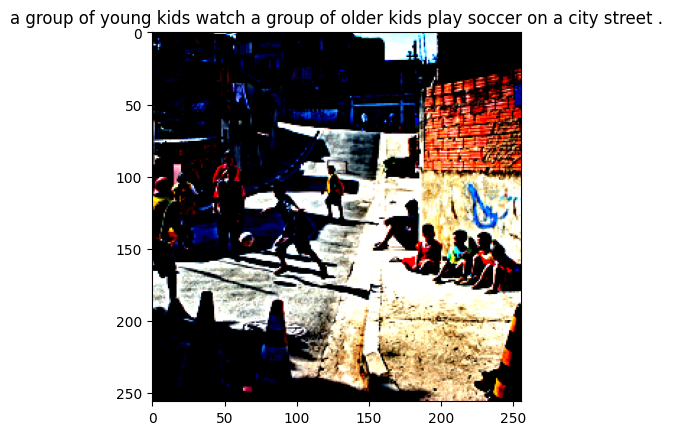

82


In [12]:
#generating the iterator from the dataloader
dataiter = iter(trainingDataloader)

#getting the next batch
batch = next(dataiter)

#unpacking the batch
images, captions, lengths = batch

#showing info of image in single batch
for i in range(1):
    img,cap,length = images[i],captions[i],lengths[i]
    
    caption_label = [trainingData.vocab.intToString[token] for token in cap.tolist()]
    eos_index = caption_label.index('<EOS>')
    caption_label = caption_label[1:eos_index]
    caption_label = ' '.join(caption_label)                      
    showImage(img,caption_label)
    print(length)
    plt.show()

In [15]:
# CREATE ENCODER MODEL

class Encoder(nn.Module):

    def __init__(self, encodedImageSize=14):
        super(Encoder, self).__init__() # Initialize a nn.Module child class
        self.encodedImageSize = encodedImageSize # How large our "encoded"/"learned" image will be


        # Pretrained image classifcation library
        resnet = torchvision.models.resnet101(pretrained=True)


        # We aren't doing classifcation, but we need the models "knowledge" on image features
        # So to use transfer learning, we need to remove the last two layers of the model
        # Because the last two are the ones that do the classifcation (linear & pooling)
        layers = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*layers)


        
        # A final layer to resize the resnets new last (previously 2nd to last) layer
        # To the target size of our encodedImage (constructor parameter) that we will then
        # pass to the decoder
        self.adaptivePool = nn.AdaptiveAvgPool2d((encodedImageSize, encodedImageSize))


        self.allowFineTuning()

    def allowFineTuning(self, allow=True):

        # Weights of pretrained models usually locked, but since we are fine-tuning
        # this model to our specific task (transfer learning), we want to unlock them
        
        # ONLY UNLOCK 2-4 because the first layer of models has typically already
        # learned something very important about the image that we don't want to change
        for param in self.resnet.parameters():
            param.requires_grad = False
        
        # See Resnet on WhatDidISee doc
        for convolutionLayer in list(self.resnet.children())[5:]:
            for param in convolutionLayer:
                param.requires_grad = allow

    
    def forward(self, images):

        # A batch of image tensors, passed forward through the layers to encode
        # "Forward propogation"

        #https://stackoverflow.com/questions/67087131/what-is-nchw-format
        # NCHW (batchSize, 3 (RGB), imageSize, imageSize)

        result = self.resnet(images)         # Pass through ResNet model --> (batchSize, 2048, size/32, size/32)
        result = self.adaptivePool(result)   # Adaptive layer --> (batchSize, 2028, encodeSize, encodeSize)
        result = result.permute(0,2,3,1)     # Rearrange dimensions --> (batchSize, encodeSize, encodeSize, 2048)

        #Layers are permuted to work for the attention model
        return result











    

In [ ]:
# Create attention network (tells us where in image to look next)
"""
Is given the intial encoded image output (batchSize, 14, 14, 2048)

Then at each forward step, it takes in the decoder state, and returns a weighted version of the image
telling the decoder where in the encoded image to look next

"""


class Attention(nn.Module):
    def __init__(self, encoderDim, decoderDim, attentionDim):
        """
        size of encoded image coming in
        size of decoder's RNN
        size of this network
        """
        super(Attention, self).__init__()
        self.encoderAtt = nn.Linear(encoderDim, attentionDim)
        self.decoderAtt nn.Linear(decoderDim, attentionDim)
        
        self.fullAttention(attentionDim, 1) 
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, encoderOut, decoderHidden):
        # Decoder hidden is the the previous output of the decoder
        

        

    

    